In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
Data = "/content/drive/MyDrive/AQI/Data/waqi_downloads"
Data_i = "/content/drive/MyDrive/AQI/Data/intermediate"

# Data Preparation

This notebook runs through the steps required to take our raw data (citypm25.csv) with air quality measurements and augment it with satellite data via Google Earth Engine, getting it into a state that is ready for modelling.

At the end is also an example of getting the same data for a new location.

# Loading the data

In [3]:
import pandas as pd
df = pd.read_csv(f"{Data_i}/citypm25.csv", parse_dates=['Date'])
df.sample(5)

,Date,Country,City,Median_PM25,Lat,Long
357690,2018-04-11,ES,Donostia / San Sebastián,17.0,43.31283,-1.97499
114318,2021-05-27,UA,Odessa,55.0,46.47747,30.73262
583606,2015-05-05,RO,Constanţa,57.0,44.18073,28.63432
194388,2019-03-28,ES,Santa Cruz de Tenerife,57.0,28.46824,-16.25462
7447,2021-01-07,AU,Brisbane,17.0,-27.46794,153.02809


# Getting Data from GEE

This requires a Google Earth Engine account.

In [4]:
import ee
# ee.Authenticate() # Run once to link your EE account

In [5]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=XV6HoPhS1ximw4Ee_Kc-UA_CClD4Xfs5zAQ7Dzabf8g&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhOFuEwkUuAOM_n4mQLnhYUhd4LyDrR4VOHTKAqaj8zOVlKat1bpaI

Successfully saved authorization token.


### Querying an image

In [6]:
# A utility function to pull data for a set of locations
def sample(im, prop, lats, lons, scale=5000, reducer=ee.Reducer.first(), tileScale=4):
    points = []
    for lat, lon in zip(lats, lons):
        xy = ee.Geometry.Point([lon, lat])
        points.append(xy.buffer(scale))
    vals = im.reduceRegions(collection=ee.FeatureCollection(points), scale=scale, reducer=reducer, tileScale=tileScale).getInfo()
    if prop == '':
        return [v['properties'] for v in vals['features']]
    return [v['properties'][prop] for v in vals['features']]

# Example:
lights = ee.ImageCollection("NOAA/DMSP-OLS/CALIBRATED_LIGHTS_V4") # An image collection
lights = lights.filter(ee.Filter.date('2010-01-01', '2018-03-08')).first() # An image
vals = sample(lights, '', [-18.136], [30.15], scale=100) # See image value for a single location
vals

[{'avg_vis': 8.628110885620117, 'cf_cvg': 84}]

### Adding static variables

For population and nighttime lights, we don't need to query for all dates as a single static value will be enough.

In [7]:
from tqdm import tqdm # Progress bar

def add_static_vars(df, scale=5000):
    lights = ee.ImageCollection("NOAA/DMSP-OLS/CALIBRATED_LIGHTS_V4").filter(ee.Filter.date('2010-01-01', '2018-03-08')).first()
    pop = ee.ImageCollection("CIESIN/GPWv411/GPW_UNWPP-Adjusted_Population_Density").filter(ee.Filter.date('2010-01-01', '2018-03-08')).first()
    ims = [lights, pop]

    for im in tqdm(ims):
        for i, reducer in enumerate([ee.Reducer.mean(), ee.Reducer.min(), ee.Reducer.max()]):
            sampled_values = sample(im, '', df['Lat'].values, df['Long'].values, reducer=reducer, scale=scale)
            for k in sampled_values[0].keys():
                arr = ['mean', 'min', 'max']
                df[k+'_'+str(scale)+'_' + arr[i]] = [sv[k] if k in sv.keys() else None for sv in sampled_values]
                if k == arr[i]:
                    df = df.rename(columns={k+'_'+str(scale)+'_' + arr[i]:'pop_density2010'+'_'+str(scale)+'_' + arr[i]})
    return df

In [8]:
# Example
cities = df.groupby('City').first().reset_index()
cities.head()

,City,Date,Country,Median_PM25,Lat,Long
0,Abidjan,2021-04-05,CI,117.0,5.35444,-4.00167
1,Abu Dhabi,2021-01-11,AE,30.0,24.45118,54.39696
2,Accra,2021-03-07,GH,93.0,5.55602,-0.19690
3,Adana,2021-01-13,TR,122.0,36.98615,35.32531
4,Adapazarı,2021-08-21,TR,30.0,40.78056,30.40333


In [9]:
add_static_vars(cities.head().copy()) # Show the result on the first 5 cities

100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


,City,Date,Country,Median_PM25,Lat,Long,avg_vis_5000_mean,cf_cvg_5000_mean,avg_vis_5000_min,cf_cvg_5000_min,avg_vis_5000_max,cf_cvg_5000_max,pop_density2010_5000_mean,pop_density2010_5000_min,pop_density2010_5000_max
0,Abidjan,2021-04-05,CI,117.0,5.35444,-4.00167,137.458238,15.998734,160.062439,16,164.259094,16,6520.705998,3082.400635,14800.669922
1,Abu Dhabi,2021-01-11,AE,30.0,24.45118,54.39696,556.621354,17.788571,475.282532,11,727.158020,23,38.947327,38.947327,38.947327
2,Accra,2021-03-07,GH,93.0,5.55602,-0.19690,119.459692,15.767176,89.985809,8,167.339310,17,11249.964753,11258.493164,11258.494141
3,Adana,2021-01-13,TR,122.0,36.98615,35.32531,167.343808,20.237030,174.905594,21,248.902603,22,273.807927,106.356522,416.175598
4,Adapazarı,2021-08-21,TR,30.0,40.78056,30.40333,92.085145,29.341346,38.168736,9,157.619995,50,668.729353,623.649292,777.632080


### Adding time-series 

We specify a date range and a set of locations, and query the satellite data for each date.

In [10]:
from datetime import timedelta

# Image Collections
gfs = ee.ImageCollection("NOAA/GFS0P25") # Weather data

S5p_collections = {} # Sentinel 5p data, which comes in multiple collections
for COL in ['L3_NO2', 'L3_O3', 'L3_CO', 'L3_HCHO', 'L3_AER_AI', 'L3_SO2', 'L3_CH4', 'L3_CLOUD']: # 
    S5p_collections[COL] = ee.ImageCollection('COPERNICUS/S5P/OFFL/'+COL).map(lambda image: image.addBands(image.metadata('system:time_start')))
# Properties for each image we want to keep
s5p_props = {
    'L3_NO2':['NO2_column_number_density', 'tropospheric_NO2_column_number_density', 'stratospheric_NO2_column_number_density', 'NO2_slant_column_number_density', 'tropopause_pressure', 'absorbing_aerosol_index'],
    'L3_O3':['O3_column_number_density', 'O3_effective_temperature'],
    'L3_CO':['CO_column_number_density', 'H2O_column_number_density', 'cloud_height'],
    'L3_HCHO':['tropospheric_HCHO_column_number_density', 'tropospheric_HCHO_column_number_density_amf', 'HCHO_slant_column_number_density'],
    'L3_CLOUD':['cloud_fraction', 'cloud_top_pressure', 'cloud_top_height', 'cloud_base_pressure', 'cloud_base_height', 'cloud_optical_depth', 'surface_albedo'],
    'L3_AER_AI':['absorbing_aerosol_index', 'sensor_altitude', 'sensor_azimuth_angle', 'sensor_zenith_angle', 'solar_azimuth_angle', 'solar_zenith_angle']
}

def add_timeseries(df, dates, reducer=ee.Reducer.first()):
    # Prepare dataframe with date x city
    date_col = []
    city_col = []
    for d in dates:
        for c in df.City.unique():
            date_col.append(d)
            city_col.append(c)

    data = pd.DataFrame({
        'Date':date_col,
        'City':city_col
    })
    data = pd.merge(data, df[['City', 'Lat', 'Long']], how='left', on='City')
    
    for d in tqdm(dates):
        # Weather is easy - a single image from the right date
        weather_image = gfs.filter(ee.Filter.date(str(d.date()), str((d+timedelta(days=1)).date()))).first() # Filter to get the relevant image
        # For the sentinel data, we get images from each collection and merge them
        s5p_images = []
        for COL in ['L3_NO2', 'L3_O3', 'L3_CO', 'L3_HCHO', 'L3_CLOUD', 'L3_AER_AI']:
            collection = S5p_collections[COL].filter(ee.Filter.date(str((d-timedelta(days=5)).date()), str(d.date())))
            image = collection.qualityMosaic('system:time_start') # The most recent image
            image = image.select(s5p_props[COL])
            s5p_images.append(image)
        s5p_image = ee.ImageCollection(s5p_images).toBands() # Merge into one image
    
        # Sample the weather data
        samples = sample(weather_image, '', df['Lat'].values, df['Long'].values, reducer=reducer)
        for prop in samples[0].keys():
            data.loc[data.Date==d, prop] = [p[prop] for p in samples]
            
        # Sample the sentinel data
        samples = sample(s5p_image, '', df['Lat'].values, df['Long'].values)
        for prop in samples[0].keys():
            data.loc[data.Date==d, prop] = [p[prop] for p in samples]
            
    return data

In [11]:
dates = pd.date_range('2020-01-01', '2020-01-04', freq='1D')
add_timeseries(cities.head(2).copy(), dates) # Show the result on the first 2 cities

100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,0_NO2_column_number_density,0_NO2_slant_column_number_density,0_absorbing_aerosol_index,0_stratospheric_NO2_column_number_density,0_tropopause_pressure,0_tropospheric_NO2_column_number_density,1_O3_column_number_density,1_O3_effective_temperature,2_CO_column_number_density,2_H2O_column_number_density,2_cloud_height,3_HCHO_slant_column_number_density,3_tropospheric_HCHO_column_number_density,3_tropospheric_HCHO_column_number_density_amf,4_cloud_base_height,4_cloud_base_pressure,4_cloud_fraction,4_cloud_optical_depth,4_cloud_top_height,4_cloud_top_pressure,4_surface_albedo,5_absorbing_aerosol_index,5_sensor_altitude,5_sensor_azimuth_angle,5_sensor_zenith_angle,5_solar_azimuth_angle,5_solar_zenith_angle
0,2020-01-01,Abidjan,5.35444,-4.00167,46.900002,71.599998,0.01616,27.196222,-1.279448,0.737317,0.000080,0.000134,0.443753,0.000025,7311.869141,0.000047,0.109680,230.759266,0.052721,3260.289040,2826.930275,0.000277,0.000350,1.031251,1393.725300,85999.439632,0.729094,12.763545,2393.725357,76400.444475,0.210954,0.443768,829252.673662,-99.609861,34.373530,-139.892125,37.710792
1,2020-01-01,Abu Dhabi,24.45118,54.39696,13.700000,57.900002,0.00938,21.856226,1.070552,2.427317,0.000079,0.000193,-0.896653,0.000035,7311.869141,0.000044,0.112962,231.012858,0.033333,1319.892140,1.000000,0.000042,0.000046,2.192960,12.465896,101278.874919,0.178693,8.218344,136.424788,100136.463061,0.116232,-0.896661,829852.620659,68.905130,51.364916,-168.537860,48.372729
2,2020-01-02,Abidjan,5.35444,-4.00167,39.100002,78.400002,0.01718,26.726831,-0.983623,-0.127395,0.000066,0.000111,0.074564,0.000025,7311.869141,0.000039,0.108641,229.199032,0.059136,3028.629612,2132.203064,0.000226,0.000256,1.177109,1983.145854,80125.469442,0.486799,7.834197,2983.145825,71068.492760,0.228787,0.074545,829199.802618,77.505699,1.974827,-145.461944,34.740573
3,2020-01-02,Abu Dhabi,24.45118,54.39696,24.700001,78.900002,0.01293,22.086816,2.776377,-0.837395,0.000060,0.000179,-0.606613,0.000036,6156.074219,0.000025,0.117436,228.046964,0.033333,1319.892140,1.000000,-0.000220,-0.000092,1.778018,12.623063,101288.169817,0.241996,7.018234,12.623063,101288.169817,0.204431,-0.606618,829409.030932,-93.015536,62.406931,-146.568458,55.436224
4,2020-01-03,Abidjan,5.35444,-4.00167,23.700001,21.100000,0.00431,25.726526,-1.589570,-1.838108,0.000088,0.000144,0.249955,0.000027,7311.869141,0.000062,0.109339,228.304651,0.068207,2509.985172,1.000000,0.000006,0.000072,0.956036,1983.145854,80125.469442,0.000000,7.834197,2983.145825,71068.492760,0.228787,0.249956,829102.729933,73.809871,37.207033,-151.997805,32.198350
5,2020-01-03,Abu Dhabi,24.45118,54.39696,22.700001,68.300003,0.01121,22.106531,-2.949570,0.211892,0.000189,0.000353,-1.097311,0.000035,6156.074219,0.000154,0.112650,229.413672,0.035915,4178.974182,2141.690093,-0.000116,-0.000054,1.297671,2268.644462,78725.379195,0.341352,10.703247,3268.644538,69699.709658,0.209119,-1.097314,829466.921028,-96.494056,45.957917,-151.247315,53.077992
6,2020-01-04,Abidjan,5.35444,-4.00167,24.500000,27.800001,0.00602,26.551019,-0.914272,-1.219441,0.000086,0.000156,0.270053,0.000025,7311.869141,0.000061,0.109726,230.102709,0.068207,2509.985172,1.000000,0.000038,0.000115,0.894262,3256.121642,68934.161933,0.055770,4.439643,4256.121642,60974.572300,0.163556,0.270056,828989.209522,71.186212,58.490274,-159.528799,30.152806
7,2020-01-04,Abu Dhabi,24.45118,54.39696,21.500000,57.100002,0.01013,23.381036,-2.624272,2.740559,0.000087,0.000171,-0.180484,0.000032,7311.869141,0.000055,0.113307,231.083833,0.038889,1368.540597,232.088756,0.000015,0.000064,1.026110,579.012015,95621.359684,0.042416,6.975509,893.990053,92765.830926,0.193594,-0.180495,829518.879536,-100.853115,18.401694,-156.296864,51.042549


# Generating the training data

Now that we have a way to add the satellite data, we can create our training data. This takes some time to run.

In [12]:
cities = df.groupby('City').first().reset_index() # The locations to query
cities.head()

,City,Date,Country,Median_PM25,Lat,Long
0,Abidjan,2021-04-05,CI,117.0,5.35444,-4.00167
1,Abu Dhabi,2021-01-11,AE,30.0,24.45118,54.39696
2,Accra,2021-03-07,GH,93.0,5.55602,-0.19690
3,Adana,2021-01-13,TR,122.0,36.98615,35.32531
4,Adapazarı,2021-08-21,TR,30.0,40.78056,30.40333


In [13]:
cities.columns

Index(['City', 'Date', 'Country', 'Median_PM25', 'Lat', 'Long'], dtype='object')

In [14]:
# Add static vars
cities_w_static = add_static_vars(cities.copy())
# Get just City + satellite data
cities_w_static = cities_w_static.drop(['Date', 'Median_PM25', 'Lat', 'Long', 'Country'], axis=1)
# Merge with df
df = pd.merge(df, cities_w_static, on='City')
df.head()

100%|██████████| 2/2 [00:14<00:00,  7.37s/it]


,Date,Country,City,Median_PM25,Lat,Long,avg_vis_5000_mean,cf_cvg_5000_mean,avg_vis_5000_min,cf_cvg_5000_min,avg_vis_5000_max,cf_cvg_5000_max,pop_density2010_5000_mean,pop_density2010_5000_min,pop_density2010_5000_max
0,2021-02-08,GR,Thessaloníki,72.0,40.64361,22.93086,275.954321,9.09619,56.371677,7,461.25235,9,11938.767445,11713.460938,16618.228516
1,2021-02-15,GR,Thessaloníki,38.0,40.64361,22.93086,275.954321,9.09619,56.371677,7,461.25235,9,11938.767445,11713.460938,16618.228516
2,2021-06-29,GR,Thessaloníki,59.0,40.64361,22.93086,275.954321,9.09619,56.371677,7,461.25235,9,11938.767445,11713.460938,16618.228516
3,2021-07-03,GR,Thessaloníki,46.0,40.64361,22.93086,275.954321,9.09619,56.371677,7,461.25235,9,11938.767445,11713.460938,16618.228516
4,2021-08-02,GR,Thessaloníki,78.0,40.64361,22.93086,275.954321,9.09619,56.371677,7,461.25235,9,11938.767445,11713.460938,16618.228516


In [15]:
dates = pd.date_range('2019-01-01', '2020-08-01', freq='1D') # Two yers of data

In [16]:
# Add timeseries
ts = add_timeseries(cities.copy(), dates, reducer=ee.Reducer.mean())
ts.head()

100%|██████████| 579/579 [1:13:38<00:00,  7.63s/it]


,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,0_NO2_column_number_density,0_NO2_slant_column_number_density,0_absorbing_aerosol_index,0_stratospheric_NO2_column_number_density,0_tropopause_pressure,0_tropospheric_NO2_column_number_density,1_O3_column_number_density,1_O3_effective_temperature,2_CO_column_number_density,2_H2O_column_number_density,2_cloud_height,3_HCHO_slant_column_number_density,3_tropospheric_HCHO_column_number_density,3_tropospheric_HCHO_column_number_density_amf,4_cloud_base_height,4_cloud_base_pressure,4_cloud_fraction,4_cloud_optical_depth,4_cloud_top_height,4_cloud_top_pressure,4_surface_albedo,5_absorbing_aerosol_index,5_sensor_altitude,5_sensor_azimuth_angle,5_sensor_zenith_angle,5_solar_azimuth_angle,5_solar_zenith_angle
0,2019-01-01,Abidjan,5.35444,-4.00167,41.505835,80.264168,0.017934,27.072158,1.341216,1.331283,6.88448e-05,0.000147219,0.847878,2.72435e-05,6156.07,4.13918e-05,0.117696,231.339,0.0570181,3078.97,1593.86,0.000247817,0.000257675,1.25442,1908.4,80752,0.208469,5.42811,2951.17,71250.6,0.234188,0.847894,829003,71.1929,58.4366,-159.04,30.5157
1,2019-01-01,Abu Dhabi,24.45118,54.39696,22.858414,60.283944,0.010405,22.992747,-3.233626,-0.852979,6.56455e-05,0.000141387,0.0696148,3.21435e-05,7311.87,3.3502e-05,0.105026,226.574,0.0351506,1277.64,161.493,0.000121726,0.000175051,0.998422,631.992,94750.1,0.0754585,8.84624,1598.39,84561.6,0.172693,0.0695958,829544,-100.836,18.52,-155.983,51.4042
2,2019-01-01,Accra,5.55602,-0.19690,47.586395,75.800003,0.017800,27.943170,1.521902,1.137090,7.09484e-05,0.000133135,0.263652,2.86274e-05,6156.07,4.21401e-05,0.117682,229.792,0.0580918,3039.38,3329.03,0.000296838,0.000293368,1.25231,3524.15,66558.8,0.25615,6.77337,4569.01,58456.4,0.212062,0.263659,829071,73.2245,42.1734,-153.232,32.2101
3,2019-01-01,Adana,36.98615,35.32531,10.086395,43.900002,0.002210,4.193170,-1.038098,-3.842910,8.90861e-05,0.000215745,-0.602687,3.04855e-05,19287.5,5.86006e-05,0.133111,223.673,0.034871,566.129,1384.82,6.02084e-05,8.77309e-05,1.10952,77.4127,100883,0.248948,5.89001,343.212,97555.4,0.234783,-0.602685,831276,-91.7879,59.0084,-152.258,65.3276
4,2019-01-01,Adapazarı,40.78056,30.40333,6.086396,72.037393,0.002796,0.400546,-0.530248,1.848013,8.76024e-05,0.000203386,-0.910631,3.53408e-05,24285,5.22617e-05,0.158957,221.998,0.0394533,518.235,416.232,0.000133786,0.000216048,0.754734,107.447,100786,0.173613,4.16143,306.514,98038.7,0.128325,-0.910631,832034,-95.2349,45.6532,-157.312,67.276


In [17]:
# Save
df.to_csv(f"{Data_i}/df_w_static.csv", index=False)
ts.to_csv(f"{Data_i}/timeseries.csv", index=False)

# Doing the same for new locations

This section shows the process of getting the same data for new locations. In this case, a list of South African cities from https://simplemaps.com/data/za-cities is used, but the same process is repeated for other locations as well.

In [ ]:
za_cities = pd.read_csv('../Data/city_locations/za_cities.csv').rename(columns={'lat':'Lat', 'lng':'Long', 'city':'City'})
za_cities = za_cities[za_cities.columns[:3]]
za_cities.head()

,City,Lat,Long
0,Johannesburg,-26.205171,28.049815
1,Cape Town,-33.925839,18.423218
2,Benoni,-26.190851,28.311338
3,Durban,-29.857896,31.029198
4,Pretoria,-25.706944,28.229444


In [ ]:
dates = pd.date_range('2019-01-01', '2020-08-01', freq='1D')

In [ ]:
# Add static vars
za_cities_w_static = add_static_vars(za_cities.copy())
za_cities_w_static.to_csv('../Data/intermediate/za_cities_w_static.csv', index=False)

100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


In [ ]:
# Add timeseries
ts = add_timeseries(za_cities.copy(), dates, reducer=ee.Reducer.mean())
ts.head()

100%|██████████| 579/579 [39:35<00:00,  4.10s/it]


,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,...,4_cloud_optical_depth,4_cloud_top_height,4_cloud_top_pressure,4_surface_albedo,5_absorbing_aerosol_index,5_sensor_altitude,5_sensor_azimuth_angle,5_sensor_zenith_angle,5_solar_azimuth_angle,5_solar_zenith_angle
0,2019-01-01,Johannesburg,-26.205171,28.049815,34.186398,74.099998,0.010470,16.683191,-1.538098,0.167090,...,102.767,6783.32,35329,0.230169,-1.041854,836021.393349,76.106556,57.231740,-81.129907,14.711944
1,2019-01-01,Cape Town,-33.925839,18.423218,13.456188,81.156772,0.011407,19.436617,0.678183,3.078934,...,6.92981,776.085,91716.9,0.141995,-1.079521,840342.500000,-103.971020,21.037430,-76.135757,28.994538
2,2019-01-01,Benoni,-26.190851,28.311338,34.186398,75.099998,0.010280,16.263177,-1.558098,0.877090,...,84.7966,6417.37,37356.5,0.22725,-1.116247,836044.182694,76.082842,56.409138,-81.389698,14.935419
3,2019-01-01,Durban,-29.857896,31.029198,38.111395,91.000004,0.016060,22.997341,-1.008098,-2.501243,...,15.5337,3051.12,96140.5,0.0963829,-2.577254,837650.235378,76.360290,49.055131,-71.997638,17.888265
4,2019-01-01,Pretoria,-25.706944,28.229444,37.486397,74.099998,0.011030,18.023187,-1.598098,3.107090,...,92.2256,5539.09,44037.8,0.21658,-0.988038,835856.500000,76.010284,56.406475,-83.254417,14.821662


In [ ]:
ts.to_csv('../Data/intermediate/za_cities_timeseries.csv', index=False)

# The following cells have been copied over, and re-create the steps above for two more datasets. Please Ignore :)

# And again for some cities across Africa 

We use a larger dataset from simplemaps and filter to get African Cities.

In [ ]:
world_cities = pd.read_csv('../Data/simplemaps_worldcities_basicv1.6/worldcities.csv')
world_cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [ ]:
af_iso2 = ['DZ','AO','BJ','BW','BF','BI','CM','CV','CF','KM','CD','DJ','EG','GQ','ER','ET','GA',
'GM','GH','GN','GW','CI','KE','LS','LR','LY','MG','MW','ML','MR','MU','MA','MZ','NE','NG','CG',
'RE','RW','SH','ST','SN','SC','SL','SO','ZA','SS','SD','SZ','TZ','TG','TN','UG','EH','ZM','ZW']
af_cities = world_cities.loc[world_cities.iso2.isin(af_iso2)].rename(columns={'lat':'Lat', 'lng':'Long', 'city':'City'})
af_cities.shape

(1466, 11)

In [ ]:
dates = pd.date_range('2019-01-01', '2020-08-01', freq='1D')
# Add static vars
af_cities_w_static = add_static_vars(af_cities.copy())
af_cities_w_static.to_csv('../Data/processed/af_cities_w_static.csv', index=False)

100%|██████████| 2/2 [02:13<00:00, 66.67s/it]


In [ ]:
ts = add_timeseries(af_cities.copy(), dates, reducer=ee.Reducer.mean())
ts.to_csv('../Data/processed/af_cities_timeseries.csv', index=False)
ts.head()

# Processing the population centers

These population centers were found using a custom Google Earth Engine script, available here: https://code.earthengine.google.com/6dc3cd0c9cf91ba69592c5ce4c54ff55

In [ ]:
# Load the cities we already have
za_cities = pd.read_csv('../Data/raw/za_cities.csv').rename(columns={'lat':'Lat', 'lng':'Long', 'city':'City'})
za_cities = za_cities[za_cities.columns[:3]]
za_cities.head()

,City,Lat,Long
0,Johannesburg,-26.205171,28.049815
1,Cape Town,-33.925839,18.423218
2,Benoni,-26.190851,28.311338
3,Durban,-29.857896,31.029198
4,Pretoria,-25.706944,28.229444


In [ ]:
pop_centers = pd.read_csv('../Data/raw/sampled_pop_centers.csv')
pop_centers.head()

,system:index,0_latitude,0_longitude,1_population_density,2_labels,2_population_density,ID,.geo
0,0_0,-31.320833,27.812500,1852.2110,107103599474910,1,0,NaN
1,1_0,-31.320833,27.820833,3827.1555,107103599474910,1,1,NaN
2,2_0,-31.329167,27.820833,2541.6377,107103599474910,1,2,NaN
3,3_0,-31.329167,27.829167,2266.2512,107103599474910,1,3,NaN
4,4_0,-31.379167,26.354167,4791.9062,106351980198117,1,4,NaN


In [ ]:
pop_centers = pop_centers[pop_centers['1_population_density'] > 1000]

In [ ]:
pop_centers.columns

Index(['system:index', '0_latitude', '0_longitude', '1_population_density',
       '2_labels', '2_population_density', 'ID', '.geo'],
      dtype='object')

In [ ]:
pcs = pop_centers.groupby('2_labels').mean().drop(['.geo'], axis=1).reset_index()
pcs['population'] = pop_centers.groupby('2_labels').sum()['2_population_density']
print(pcs.shape)
pcs.head()

(709, 7)


,2_labels,0_latitude,0_longitude,1_population_density,2_population_density,ID,population
0,101906689046502,-29.264167,17.732500,1864.426140,1.0,3539.000000,NaN
1,101979703490581,-29.650833,17.872500,2038.622720,1.0,3555.000000,NaN
2,101988293425553,-32.812500,17.891667,1100.177050,1.0,597.500000,NaN
3,102001178327463,-33.007197,17.920076,3090.803955,1.0,632.363636,NaN
4,102018358196232,-29.543056,17.948611,1496.952667,1.0,3547.000000,NaN


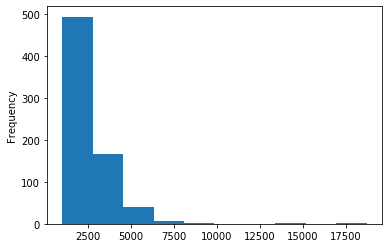

In [ ]:
pcs['1_population_density'].plot(kind='hist')

In [ ]:
# Filter out those within a few km of the cities we;ve already done
labels = []
for lab, lat, lon in pcs[['2_labels', '0_latitude', '0_longitude']].values:
    close = False
    for clat, clon in za_cities[['Lat', 'Long']].values:
        if ((lat-clat)**2 + (lon-clon)**2)**0.5 < 0.2: # ~20km
            close=True
            break
    if not close:
        labels.append(lab)
        
len(labels)

496

In [ ]:
pcs = pcs.rename(columns={'2_labels':'City', '0_latitude':'Lat', '0_longitude':'Long'})
pcs = pcs.loc[pcs.City.isin(labels)]
pcs.to_csv('../Data/processed/pop_centers_sa.csv', index=False)

In [ ]:
dates = pd.date_range('2019-01-01', '2020-08-01', freq='1D')
# Add static vars
pcs_w_static = add_static_vars(pcs.copy())
pcs_w_static.to_csv('../Data/processed/pcs_w_static.csv', index=False)



  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:30<00:30, 30.51s/it]

100%|██████████| 2/2 [01:00<00:00, 30.45s/it]


In [ ]:
ts = add_timeseries(pcs.copy(), dates, reducer=ee.Reducer.mean())
ts.to_csv('../Data/processed/pcs_timeseries.csv', index=False)
ts.head()